In [1]:
#import standard libs
import numpy as np
import pandas as pd
import time
import numpy.fft as fft
import importlib
from tqdm import tqdm
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "plotly_mimetype"

In [2]:
#custom function files
import parameter_utils as pu
import mt_utils as ut

In [3]:
importlib.reload(ut)

<module 'mt_utils' from 'E:\\Melli\\HU\\Masterarbeit Save\\Implementation\\mt_utils.py'>

In [4]:
importlib.reload(pu)

<module 'parameter_utils' from 'E:\\Melli\\HU\\Masterarbeit Save\\Implementation\\parameter_utils.py'>

In [5]:
#import claspy
from claspy.data_loader import load_tssb_dataset
from claspy.data_loader import load_has_dataset
from claspy.segmentation import BinaryClaSPSegmentation
from claspy.tests.evaluation import covering

In [6]:
tssb = load_tssb_dataset()
hasc = load_has_dataset()

In [7]:
# load prepared results
tssb_res = pd.read_pickle('results/zwischenergebnisse/clasp_on_downsampled_TS_TSSB_origW.pkl')
tssb_ds = pd.read_pickle('results/zwischenergebnisse/all_downsampled_TSSB.pkl')

hasc_res = pd.read_pickle('results/zwischenergebnisse/clasp_on_downsampled_TS_HASC_origW.pkl')
hasc_ds = pd.read_pickle('results/zwischenergebnisse/all_downsampled_HASC.pkl')

In [8]:
#test compression = 0.5, obtained from 1_splitting
cr = 0.5
tssb_res_filtered = tssb_res[tssb_res['compression']==cr]
hasc_res_filtered = hasc_res[hasc_res['compression']==cr]

columns = ['upscaled_cps_lin', 'upscaled_cps_idx', 'score_lin', 'score_idx']

# Functions and Variables

## Bucket Getters

In [9]:
def get_bucket_indizes(cp_list,ds_algo,cf,ts,downscaled):
    indizes = []
    for cp in cp_list:
        indizes.append(define_bucket(cp, ds_algo, cf, ts, downscaled)[0])
    return indizes

In [10]:
def get_largest_index_difference(indexlist1, indexlist2): 
    l1_sorted = sorted(indexlist1)
    l2_sorted = sorted(indexlist2)
    max_difference = 0
    while l1_sorted and l2_sorted:
        min_distance = float('inf')
        best_pair = None
        
        for elem_l1 in l1_sorted:
            for elem_l2 in l2_sorted:
                distance = abs(elem_l1 - elem_l2)
                if distance < min_distance:
                    min_distance = distance
                    best_pair = (elem_l1, elem_l2)
        
        difference = best_pair[0] - best_pair[1]
        
        if max_difference is None or abs(difference) > abs(max_difference):
            max_difference = difference
        
        l1_sorted.remove(best_pair[0])
        l2_sorted.remove(best_pair[1])
        
    return int(max_difference)

In [11]:
def add_bucket_index_differences(dataset,original):
    df = dataset.copy()
    df['max_index_diff']=None
    for index, row in tqdm(df.iterrows(), total=len(df), desc="Processing rows"):
        indizes_ds = get_bucket_indizes(row.ds_predictions,row.algo,row.compression,original.iloc[row.orig_TS_ID].time_series,True)
        indizes_orig = get_bucket_indizes(row.true_cps,row.algo,row.compression,original.iloc[row.orig_TS_ID].time_series,False)
        max_diff = get_largest_index_difference(indizes_ds,indizes_orig)
        df.at[index,'max_index_diff']=int(max_diff)
    return df.astype({'max_index_diff': 'int32'})

In [12]:
def define_bucket(cp,ds_algo,cf,ts,downscaled,bucket_range=0):
    #all ts in multivariate have same length, so this can simply be done using any ts in the set
    # B = bucket size
    n = ts.shape[0]
    match ds_algo:
        case 'MinMax':
            B = 2/cf
            P = 2
        case 'M4':
            B = 4/cf
            P = 4
        case 'MinMaxLTTB':
            B = int((n-2)/((cf*n)-2))
            P = 1
        case 'LTTB':
            B = int((n-2)/((cf*n)-2))
            P = 1
        case 'LTD':
            #bucket size is dynamic but mean must be the same as lttb bucket size
            B = int((n-2)/((cf*n)-2))
            P = 1
        case 'EveryNth':
            B = 1/cf
            P = 1
    if downscaled:
        bucket_index = np.ceil(cp/P)
    else:
        bucket_index = np.ceil(cp/B)
        
    lbucket=bucket_index-bucket_range
    ubucket=bucket_index+bucket_range
    index_range = [int((lbucket-1)*B), int(ubucket*B)]
    
    # check lrange or rrange is out of bounds
    if index_range[1] > ts.shape[0]:
        index_range[1]=ts.shape[0]-1
    if index_range[0]<0:
        index_range[0]=0
    # can happen with upper bound restriction
    if index_range[0]>index_range[1]:
        index_range[0]=int(index_range[1]-(bucket_range*B))
        
    return int(bucket_index), index_range

## Level Scaling

In [13]:
def upscale_cps_linear(ds_cps, cf):
    return (ds_cps*(1/cf)).astype(int)

In [14]:
def upscale_cps_index(ds_cps,index_lists):
    if index_lists.ndim==1:
        out = index_lists[ds_cps]
    else:
        # use first three channels as hasc winners
        channels = index_lists[:,:3]
        cps = []
        for i in range(channels.shape[1]):
            channel = channels[:,i]
            cps = np.union1d(cps, channel[ds_cps])
        out = ut.prune_cps(cps)
    return out

In [15]:
def upscale_change_points_all(dataset, downsampled, original):
    upscaling_scores = []

    for index, row in tqdm(dataset.iterrows(), total=len(dataset), desc="Processing rows"):
        orig = original.iloc[row.orig_TS_ID]

        if len(row.ds_predictions)==0:
            u_cps_lin = []
            u_cps_idx = []
        else:
            u_cps_lin = upscale_cps_linear(row.ds_predictions, row.compression)
            index_lists = downsampled[(downsampled.Orig_TS_ID==row.orig_TS_ID) & (downsampled.DS_Algo==row.algo) & (downsampled.CF==row.compression)].DS_TS_index.values[0]
            u_cps_idx = upscale_cps_index(row.ds_predictions, index_lists)
    
        score_lin = covering({0: orig.cps}, u_cps_lin, orig.time_series.shape[0])
        score_idx = covering({0: orig.cps}, u_cps_idx, orig.time_series.shape[0])

        upscaling_scores.append((u_cps_lin, u_cps_idx, score_lin, score_idx))
        
    return upscaling_scores

In [16]:
def score_comparison_matrix_levelScaling(df):
    mean_lin = np.mean(df['score_lin'])
    median_lin = np.median(df['score_lin'])
    std_lin = np.std(df['score_lin'])
    
    mean_idx = np.mean(df['score_idx'])
    median_idx = np.median(df['score_idx'])
    std_idx = np.std(df['score_idx'])
    
    lin_idx_agg = pd.DataFrame([[mean_lin, mean_idx], [median_lin, median_idx], [std_lin, std_idx]], 
                               columns=['Linear upscaling','Index upscaling'], 
                               index=['mean','median','std']
                              )
    lin_idx_agg['Diff'] = lin_idx_agg['Linear upscaling'] - lin_idx_agg['Index upscaling']
    return lin_idx_agg

## Fine Tuning

In [17]:
def window_features(ts,dcps,ds_algo,cf,w_size,bucket_range):
    #get index interval for each cp (bucket)
    global_w = w_size
    ucps = []
    for cp in dcps:
        bucket_index, bucket = define_bucket(cp,ds_algo,cf,ts,True,bucket_range=bucket_range)
        bucket[0] = max(bucket[0], w_size)          # Ensure enough room for a window before
        bucket[1] = min(bucket[1], len(ts) - w_size - 1)  # Ensure enough room for a window after
        bucket_size = bucket[1]-bucket[0]
        segment = np.arange(bucket[0],bucket[1]+1)
        max_dist = -np.inf
        i_max = None

        for i in segment:
            #for each point (index) calculate clasp similarity of w before p and after p
            #highest dissimilarity is the cp
            #define windows before and after index
            
            w_before = ts[i - w_size:i]
            w_after = ts[i:i + w_size]           
            
            dist = ut.z_ED_fft(w_before,w_after)
                
            if dist > max_dist:
                max_dist = dist
                i_max = i
        
        ucps.append(i_max)    
    return ucps

In [18]:
def local_clasp(ts,dcps,ds_algo,cf,bucket_range):
    ucps = []
    for cp in dcps:
        bucket_index, segment = define_bucket(cp,ds_algo,cf,ts,True,bucket_range=bucket_range)
        ts_segment = ts[segment[0]:segment[1]]
        curr_ucps = BinaryClaSPSegmentation().fit_predict(ts_segment)
        if len(curr_ucps)==0:
            ucps = np.union1d(ucps,[cp])
        else:
            ucps = np.union1d(ucps,curr_ucps)
    ucps = ut.prune_cps(ucps)
    return [int(cp) for cp in ucps]

In [19]:
methods = ['maximum_diff', 'gradient', 'moving_avg', 'window_features', 'local_clasp']
def fine_tune_ucps(method, ts, data_row):
    ucps = data_row.upscaled_cps_lin
    ft_cps = []
    output = []
    if ts.ndim == 1:
        ts_arr = np.array([ts])
    else:
        ts_arr = np.transpose(ts)
    runtime = time.process_time()
    for ts in ts_arr:
        if method == 'window_features':
            w = pu.get_window_size_multivariate(ts) 
            output = window_features(ts,data_row.ds_predictions,data_row.algo,data_row.compression,w,abs(data_row.max_index_diff))
        elif method == 'local_clasp':
            output = local_clasp(ts,data_row.ds_predictions,data_row.algo,data_row.compression,abs(data_row.max_index_diff))
        else:       
            for i, cp in enumerate(ucps):
                bucket_index, window = define_bucket(data_row.ds_predictions[i], data_row.algo, data_row.compression, ts,False,abs(data_row.max_index_diff))
                window_size = window[1]-window[0]
        
                cp_segment = ts[window[0]:window[1]]
                if method == 'maximum_diff':
                    base = np.abs(np.diff(cp_segment))
                elif method == 'gradient':
                    base = np.abs(np.gradient(cp_segment))
                elif method == 'moving_avg':
                    smooth_series = pd.Series(cp_segment).rolling(window=window_size).mean()
                    base = np.abs(cp_segment - smooth_series)
                        
                best_cp = window[0] + np.argmax(base)
                ft_cps.append(best_cp)
            
            output = np.union1d(output,ft_cps)

    if ts.ndim > 1:
        output = ut.prune_cps(output)
    runtime = time.process_time()-runtime
    return [int(cp) for cp in output], runtime

In [20]:
def upscale_cps_finetuned(data_ucps,data_orig,methods,quantils):
    threshold = abs(min(quantils))
    import warnings
    warnings.simplefilter("ignore")
    fine_tuned_results = []
    for index, row in tqdm(data_ucps.iterrows(), total=len(data_ucps), desc="Processing rows"):
        orig = data_orig.iloc[row.orig_TS_ID]
        fine_tuned_results.append(('LinearScaling', row.score_lin, row.runtime))
        for method in methods:
            # only fine tune when individual bucket range exceeds threshold
            if abs(row.max_index_diff)>threshold:
                try:
                    ft_cps, runtime = fine_tune_ucps(method,orig.time_series,row)
                except:
                    ft_cps, runtime = row.upscaled_cps_lin, row.runtime
            else:
                ft_cps, runtime = row.upscaled_cps_lin, row.runtime
                
            score = covering({0: orig.cps}, ft_cps, orig.time_series.shape[0])
    
            fine_tuned_results.append((method, score, runtime))
    return fine_tuned_results

In [21]:
def score_comparison_matrix_fineTuning(df):
    mean = df.groupby(by=['method']).mean().rename(columns={'score_lin': 'mean'})
    median = df.groupby(by=['method']).median().rename(columns={'score_lin': 'median'})
    std = df.groupby(by=['method']).std().rename(columns={'score_lin': 'std'})
    
    out = mean.merge(median, left_on='method', right_on='method')
    out = out.merge(std, left_on='method', right_on='method')
    out = out.transpose()
    return out[['LinearScaling','maximum_diff', 'gradient', 'moving_avg', 'window_features', 'local_clasp']]

In [22]:
def add_upscaled_and_score(input_df, original, method):
    df = input_df.copy()
    df['ucps']=None
    df['score']=None
    for index, row in tqdm(df.iterrows(), total=len(df), desc="Processing rows"):
        orig_ts = original.iloc[row.orig_TS_ID].time_series
        if method == 'linear':
            if len(row.ds_predictions)>0:
                ucps = upscale_cps_linear(row.ds_predictions,row.compression)
            else: 
                ucps=[]
        elif method == 'window_features':
            if orig_ts.ndim == 1:
                ts_arr = np.array([orig_ts])
            else:
                ts_arr = np.transpose(orig_ts)

            for ts in ts_arr:
                w = pu.get_window_size_multivariate(ts)
                indizes_ds = get_bucket_indizes(row.ds_predictions,row.algo,row.compression,orig_ts,True)
                indizes_orig = get_bucket_indizes(row.true_cps,row.algo,row.compression,orig_ts,False)
                max_diff = get_largest_index_difference(indizes_ds,indizes_orig)
                ucps = window_features(ts,row.ds_predictions,row.algo,row.compression,w,bucket_range)
            
            if orig_ts.ndim > 1:
                ucps = ut.prune_cps(ucps)            
            
        score = covering({0: row.true_cps}, ucps, orig_ts.shape[0])
        
        df.at[index,'ucps']=ucps
        df.at[index,'score']=score
    return df

# Level Scaling

## TSSB

In [ ]:
upscaled_cps_tssb = upscale_change_points_all(tssb_res_filtered, tssb_ds, tssb)

In [ ]:
upscaled_cps_tssb_df = pd.DataFrame(upscaled_cps_tssb, columns=columns)
upscaled_cps_tssb_df = pd.concat([tssb_res_filtered.reset_index(drop=True),upscaled_cps_tssb_df], axis=1)
upscaled_cps_tssb_df.to_pickle("results/zwischenergebnisse/2a_upscaled_cps_level_tssb.pkl")
upscaled_cps_tssb_df.head()

In [24]:
level_scaling_scores_tssb = score_comparison_matrix_levelScaling(upscaled_cps_tssb_df)
level_scaling_scores_tssb.to_excel("results/tables/summary_statistics_linear_index_upscaling_TSSB.xlsx")
level_scaling_scores_tssb

,Linear upscaling,Index upscaling,Diff
mean,0.753692,0.753850,-0.000158
median,0.804925,0.805044,-0.000120
std,0.244188,0.244241,-0.000053


## HASC

In [ ]:
upscaled_cps_hasc = upscale_change_points_all(hasc_res_filtered, hasc_ds, hasc)

In [ ]:
upscaled_cps_hasc_df = pd.DataFrame(upscaled_cps_hasc, columns=columns)
upscaled_cps_hasc_df = pd.concat([hasc_res_filtered.reset_index(drop=True),upscaled_cps_hasc_df], axis=1)
upscaled_cps_hasc_df.to_pickle("results/zwischenergebnisse/2a_upscaled_cps_level_hasc.pkl")
upscaled_cps_hasc_df.head()

In [26]:
level_scaling_scores_hasc = score_comparison_matrix_levelScaling(upscaled_cps_hasc_df)
level_scaling_scores_hasc.to_excel("results/tables/summary_statistics_linear_index_upscaling_HASC.xlsx")
level_scaling_scores_hasc

,Linear upscaling,Index upscaling,Diff
mean,0.711923,0.712541,-0.000617
median,0.746093,0.744481,0.001612
std,0.234708,0.235130,-0.000422


# Bucket Test

## TSSB

In [27]:
upscaled_cps_tssb_df = add_bucket_index_differences(upscaled_cps_tssb_df,tssb)

Processing rows: 100%|█████████████████████████████████████████████████████████████| 450/450 [00:00<00:00, 3626.64it/s]


In [28]:
data=upscaled_cps_tssb_df.max_index_diff.values
q1_tssb = int(np.percentile(data, 25))
q3_tssb = int(np.percentile(data, 75))
print(f"Der Interquartilsbereich (IQR) liegt zwischen {q1_tssb} und {q3_tssb}")

Der Interquartilsbereich (IQR) liegt zwischen -8 und 7


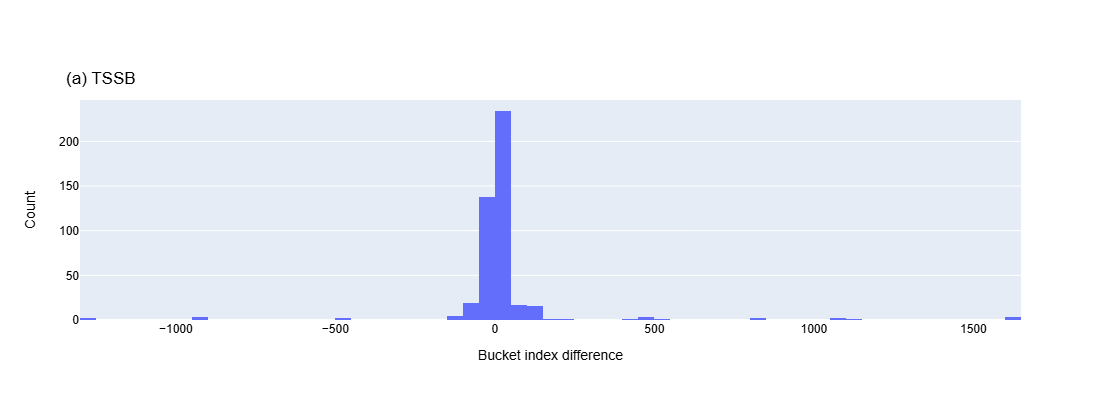

In [29]:
fig = go.Figure(data=[go.Histogram(x=upscaled_cps_tssb_df.max_index_diff)])
fig.update_layout(
    xaxis_title_text='Bucket index difference', # xaxis label
    yaxis_title_text='Count', # yaxis label
    height=400, 
    font=dict(
            family="Arial",
            size=12,
            color="black"
            ),
    title=dict(
            text="(a) TSSB",
            y=0.82,
            x=0.06
            )
)
fig.write_image("results/figures/distribution_bucket_index_diffs_TSSB.svg", scale=1, width=1000, height=400)
fig.show()

## HASC

In [30]:
upscaled_cps_hasc_df = add_bucket_index_differences(upscaled_cps_hasc_df,hasc)

Processing rows: 100%|███████████████████████████████████████████████████████████| 1500/1500 [00:00<00:00, 3489.59it/s]


In [31]:
data=upscaled_cps_hasc_df.max_index_diff.values
q1_hasc = int(np.percentile(data, 25))
q3_hasc = int(np.percentile(data, 75))
print(f"Der Interquartilsbereich (IQR) liegt zwischen {q1_hasc} und {q3_hasc}")

Der Interquartilsbereich (IQR) liegt zwischen -24 und 13


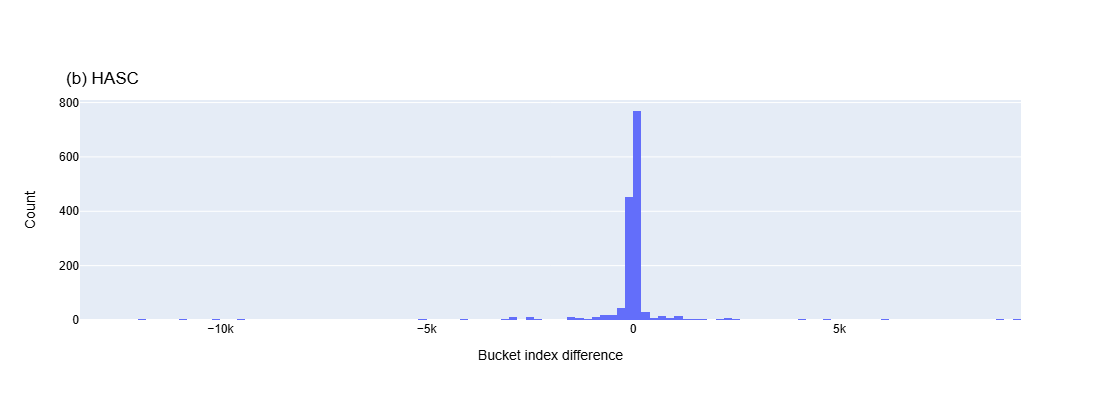

In [32]:
fig = go.Figure(data=[go.Histogram(x=upscaled_cps_hasc_df.max_index_diff)])
fig.update_layout(
    xaxis_title_text='Bucket index difference', # xaxis label
    yaxis_title_text='Count', # yaxis label
    height=400, 
    font=dict(
            family="Arial",
            size=12,
            color="black"
            ),
    title=dict(
            text="(b) HASC",
            y=0.82,
            x=0.06
            )
)
fig.write_image("results/figures/distribution_bucket_index_diffs_HASC.svg", scale=1, width=1000, height=400)
fig.show()

# Bucket Scaling

## TSSB

In [ ]:
finetuned_upscaled_cps_tssb = upscale_cps_finetuned(upscaled_cps_tssb_df,tssb,methods,[q1_tssb,q3_tssb])

In [ ]:
finetuned_upscaled_cps_tssb_df = pd.DataFrame(finetuned_upscaled_cps_tssb, columns=['method','score_lin','runtime'])

In [37]:
fine_tuned_score_sumMat_tssb = score_comparison_matrix_fineTuning(finetuned_upscaled_cps_tssb_df[['method','score_lin']])
fine_tuned_score_sumMat_tssb.to_excel("results/tables/summary_statistics_UCPS_finetuning_TSSB.xlsx")
fine_tuned_score_sumMat_tssb

,LinearScaling,maximum_diff,gradient,moving_avg,window_features,local_clasp
mean,0.753692,0.586549,0.587903,0.599211,0.738173,0.583582
median,0.804925,0.515549,0.514394,0.524182,0.788770,0.520388
std,0.244459,0.248895,0.247328,0.244405,0.247832,0.250637


In [ ]:
# add upscaled cps with best approach to dataframe and save (linear)
tssb_res_dsW = pd.read_pickle('results/zwischenergebnisse/clasp_on_downsampled_TS_TSSB_dsW.pkl')
tssb_res_ucps_dsW = add_upscaled_and_score(tssb_res_dsW, tssb, 'linear')
tssb_res_ucps_dsW.to_pickle("results/zwischenergebnisse/clasp_on_downsampled_TS_TSSB_dsW_ucps.pkl")

## HASC

In [ ]:
finetuned_upscaled_cps_hasc = upscale_cps_finetuned(upscaled_cps_hasc_df,hasc,methods,[q1_hasc,q3_hasc])

In [ ]:
finetuned_upscaled_cps_hasc_df = pd.DataFrame(finetuned_upscaled_cps_hasc, columns=['method','score_lin','runtime'])

In [39]:
fine_tuned_score_sumMat_hasc = score_comparison_matrix_fineTuning(finetuned_upscaled_cps_hasc_df[['method','score_lin']])
fine_tuned_score_sumMat_hasc.to_excel("results/tables/summary_statistics_UCPS_finetuning_HASC.xlsx")
fine_tuned_score_sumMat_hasc

,LinearScaling,maximum_diff,gradient,moving_avg,window_features,local_clasp
mean,0.711923,0.594099,0.595913,0.616230,0.709206,0.599604
median,0.746093,0.513660,0.516261,0.559911,0.748678,0.519361
std,0.234787,0.261855,0.260407,0.249577,0.238803,0.260045


In [ ]:
# add upscaled cps with best approach to dataframe and save
hasc_res_ucps = add_upscaled_and_score(hasc_res, hasc, 'linear')
hasc_res_ucps.to_pickle("results/zwischenergebnisse/clasp_on_downsampled_TS_HASC_origW_ucps.pkl")

hasc_res_dsW = pd.read_pickle('results/zwischenergebnisse/clasp_on_downsampled_TS_HASC_dsW.pkl')
hasc_res_ucps_dsW = add_upscaled_and_score(hasc_res_dsW, hasc, 'linear')
hasc_res_ucps_dsW.to_pickle("results/zwischenergebnisse/clasp_on_downsampled_TS_HASC_dsW_ucps.pkl")